`wu_perfect_lin_tau_0_phase_NN_training.ipynb`

> Proof of concept:
 - Determine the slope of the line using a TensorFlow NN
 - Lines here are wrapped noise free angle data with phase = 0
 - Data contained in `wu_perfect_lin_tau_0_phase_10000.csv`

##### imports

In [1]:
import pandas as pd, tensorflow as tf,  matplotlib.pyplot as plt, sys
from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
from plot_styles import set_plotstyles
set_plotstyles()
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/andrew/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### import and preprocess data

In [2]:
#import data
data_path = 'data/wu_perfect_lin_tau_0_phase_10000.csv'
data_df = pd.read_csv(data_path, dtype = float)

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('slope', axis = 1).values
Y_training = training_data_df[['slope']].values

X_testing = testing_data_df.drop('slope', axis = 1).values
Y_testing = testing_data_df[['slope']].values

# setup data scalers
X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

#### Setup NN round 1

In [3]:
# setup layer & NN parameters
number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

layer_1_nodes = 115
layer_2_nodes = 280
layer_3_nodes = 160

learning_rate = 0.0015
training_epochs = 1500

In [4]:
# create log path from parameters
logdir = str(layer_1_nodes) + '_' + str(layer_2_nodes) + '_' + str(layer_3_nodes)
logdir += '_a'

In [5]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
saver = tf.train.Saver()

#### Train NN round 1

In [ ]:
saver = tf.train.Saver()

with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

#### Test NN round 1

> Lets load up the saved model and compare the predictions it makes against our test data.

In [6]:
with tf.Session() as session:
    saver.restore(session,'logs/115_280_160_a_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/115_280_160_a_model/trained_model.ckpt


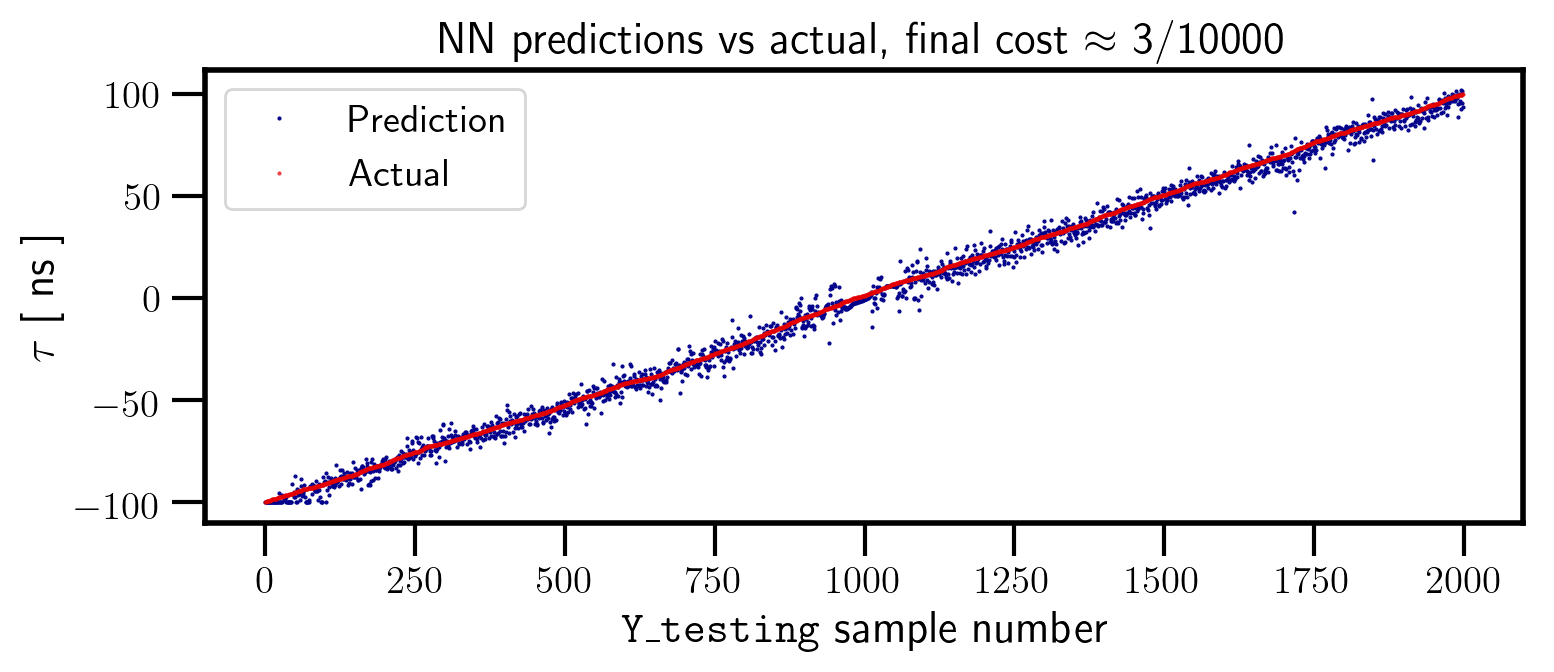

In [7]:
sorting_idx = np.argsort(Y_testing.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title(r'NN predictions vs actual, final cost $\approx$ 3/10000')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [8]:
NN_SCORE = sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

0.7627160475910233

> Not great. Lets try again with more epochs.

##### Training round 2

In [9]:
training_epochs = 2500

# change log path
logdir = str(layer_1_nodes) + '_' + str(layer_2_nodes) + '_' + str(layer_3_nodes)
logdir += '_b'

In [10]:
saver = tf.train.Saver()

In [ ]:
with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

#### Test NN round 2

> Lets load up the saved model and compare the predictions it makes against our test data.

In [11]:
with tf.Session() as session:
    saver.restore(session,'logs/115_280_160_b_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/115_280_160_b_model/trained_model.ckpt


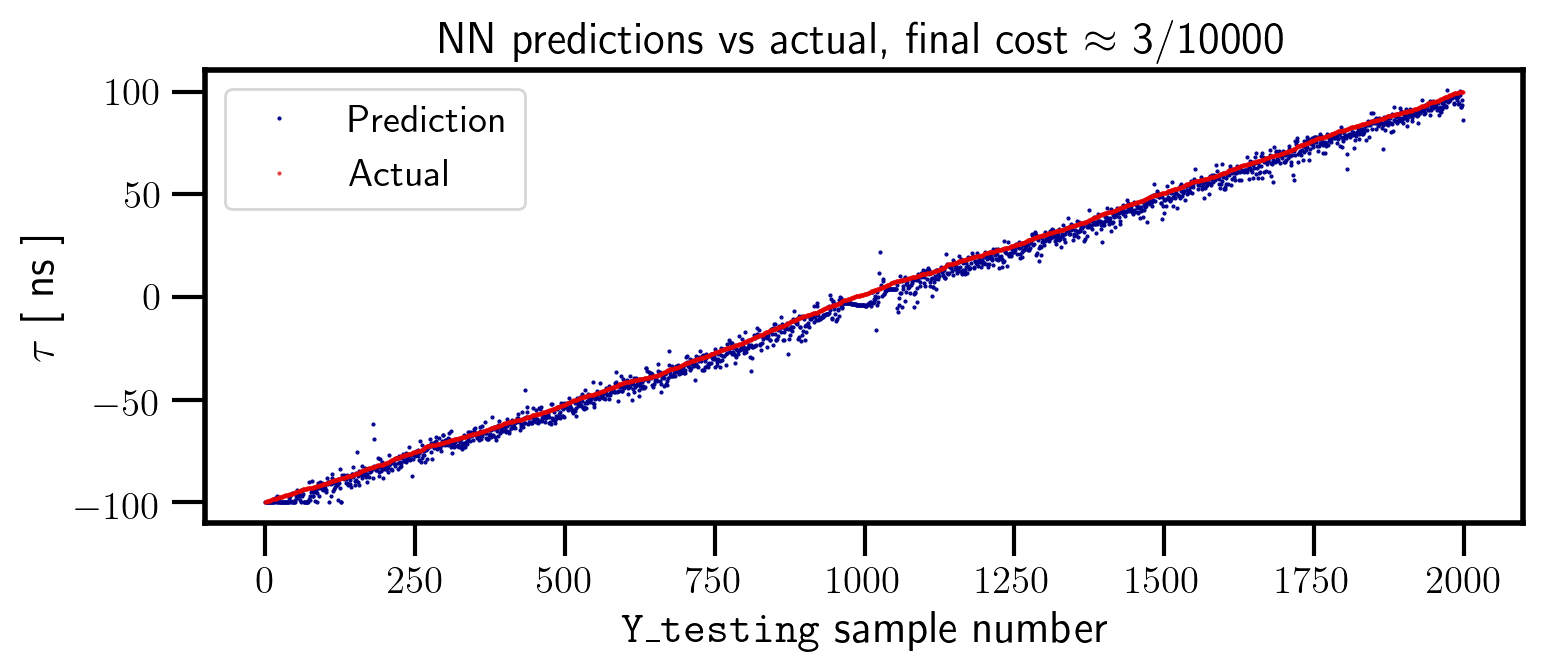

In [12]:
sorting_idx = np.argsort(Y_testing.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title(r'NN predictions vs actual, final cost $\approx$ 3/10000')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [13]:
NN_SCORE = sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

0.7407312912285147

> Not much change. Lets go back to 1500 epochs, and instead change the number of layer nodes

##### Setup round 3

In [14]:
layer_1_nodes = 115
layer_2_nodes = 280
layer_3_nodes = 115

learning_rate = 0.0015
training_epochs = 1500

In [15]:
# change log path
logdir = str(layer_1_nodes) + '_' + str(layer_2_nodes) + '_' + str(layer_3_nodes)
logdir += '_a'

> have to rerun the NN setup

In [16]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

saver = tf.train.Saver()

#### Train round 3

In [ ]:
with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

#### Test NN round 3

> Lets load up the saved model and compare the predictions it makes against our test data.

In [17]:
with tf.Session() as session:
    saver.restore(session,'logs/115_280_115_a_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/115_280_115_a_model/trained_model.ckpt


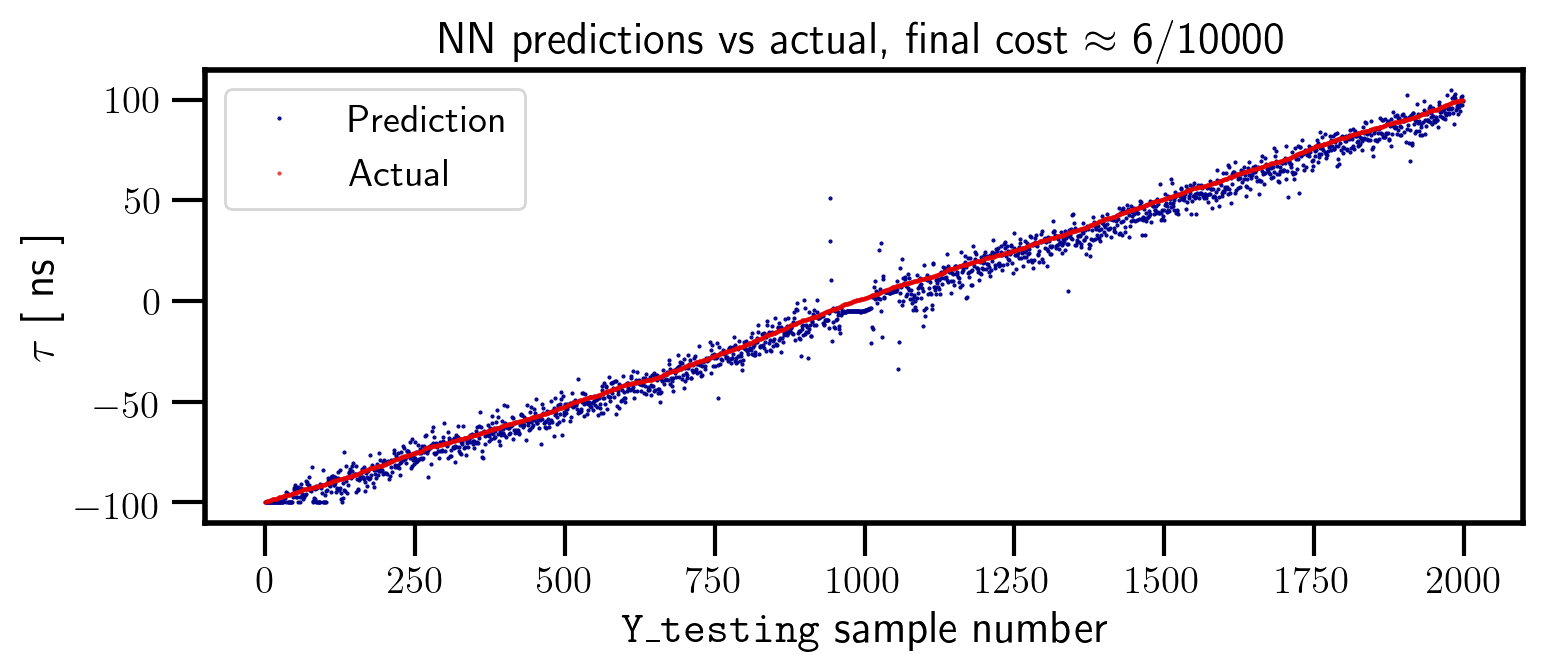

In [18]:
sorting_idx = np.argsort(Y_testing.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title(r'NN predictions vs actual, final cost $\approx$ 6/10000')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [19]:
NN_SCORE = sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

1.519833352122615

> Reducing the number of neurons in the third layer seems to have produced a worse result. Lets set those back to 160

> Lets try adding a few more layers to the network... 

#### NN Setup 4 - More layers

In [20]:
layer_1_nodes = 115
layer_2_nodes = 280
layer_3_nodes = 450
layer_4_nodes = 290
layer_5_nodes = 160

learning_rate = 0.0015
training_epochs = 1500

In [21]:
# change log path
logdir = str(layer_1_nodes) + '_' + str(layer_2_nodes) + '_' + str(layer_3_nodes) + '_' + str(layer_4_nodes)+ '_' + str(layer_5_nodes) 
logdir += '_b'

In [22]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Layer 4
with tf.variable_scope('layer_4'):

    biases = tf.get_variable(name = "biases4",
                             shape = [layer_4_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights4",
                              shape  = [layer_3_nodes, layer_4_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_4_output = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)


# Layer 5
with tf.variable_scope('layer_5'):

    biases = tf.get_variable(name = "biases5",
                             shape = [layer_5_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights5",
                              shape  = [layer_4_nodes, layer_5_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_5_output = tf.nn.relu(tf.matmul(layer_4_output, weights) + biases)


# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_5_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_5_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
saver = tf.train.Saver()

#### Training round 4

In [ ]:


with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

> Adding in two layers increase the amound of time it takes to train (about double). Also increases how quickly the cost reduces in the initial few hundred epochs

#### Test NN round 5

> Lets load up the saved model and compare the predictions it makes against our test data.

In [36]:
with tf.Session() as session:
    saver.restore(session,'logs/115_280_450_290_160_b_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/65_115_280_550_205_102_50_a_model/trained_model.ckpt


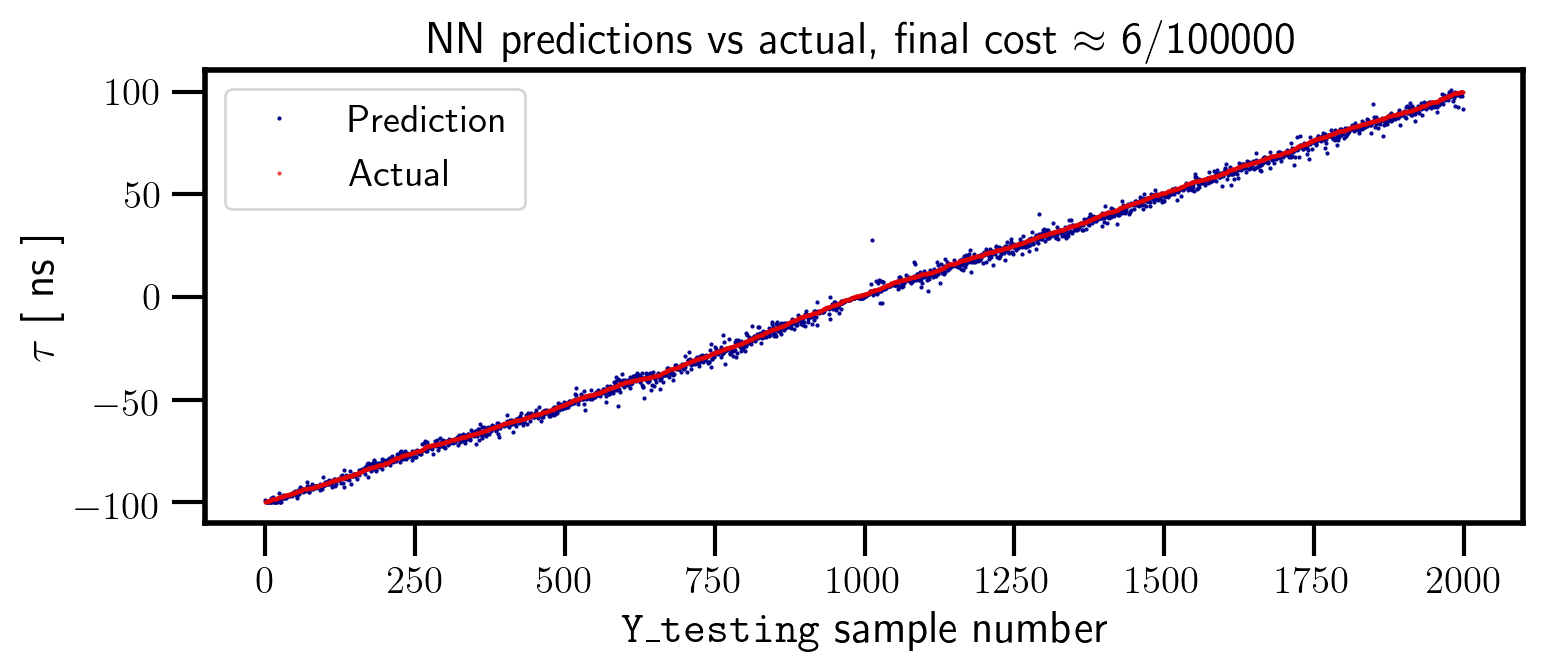

In [24]:
sorting_idx = np.argsort(Y_testing.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title(r'NN predictions vs actual, final cost $\approx$ 6/100000')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [25]:
NN_SCORE = sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

0.21791421985397627

> Better. But i would like this number to much much lower

##### NN Setup Round 5

> more layers...

In [41]:
layer_1_nodes = 115
layer_2_nodes = 280
layer_3_nodes = 450
layer_4_nodes = 290
layer_5_nodes = 205
layer_6_nodes = 105
layer_7_nodes = 50

learning_rate = 0.0015
training_epochs = 1500

In [42]:
# change log path
logdir = str(layer_1_nodes) + '_' + str(layer_2_nodes) + '_' + str(layer_3_nodes) + '_' + str(layer_4_nodes) + '_' + str(layer_5_nodes) + '_' + str(layer_6_nodes) + '_' + str(layer_7_nodes)
logdir += '_b'

In [43]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Layer 4
with tf.variable_scope('layer_4'):

    biases = tf.get_variable(name = "biases4",
                             shape = [layer_4_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights4",
                              shape  = [layer_3_nodes, layer_4_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_4_output = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)


# Layer 5
with tf.variable_scope('layer_5'):

    biases = tf.get_variable(name = "biases5",
                             shape = [layer_5_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights5",
                              shape  = [layer_4_nodes, layer_5_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_5_output = tf.nn.relu(tf.matmul(layer_4_output, weights) + biases)

# Layer 6
with tf.variable_scope('layer_6'):

    biases = tf.get_variable(name = "biases6",
                             shape = [layer_6_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights6",
                              shape  = [layer_5_nodes, layer_6_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_6_output = tf.nn.relu(tf.matmul(layer_5_output, weights) + biases)

# Layer 7
with tf.variable_scope('layer_7'):

    biases = tf.get_variable(name = "biases7",
                             shape = [layer_7_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights7",
                              shape  = [layer_6_nodes, layer_7_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_7_output = tf.nn.relu(tf.matmul(layer_6_output, weights) + biases)




# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_7_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_7_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
saver = tf.train.Saver()

##### Training round 5

In [ ]:


with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

#### Test NN round 5

> Lets load up the saved model and compare the predictions it makes against our test data.

In [44]:
with tf.Session() as session:
    saver.restore(session,'logs/115_280_450_290_205_105_50_b_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/115_280_450_290_205_105_50_b_model/trained_model.ckpt


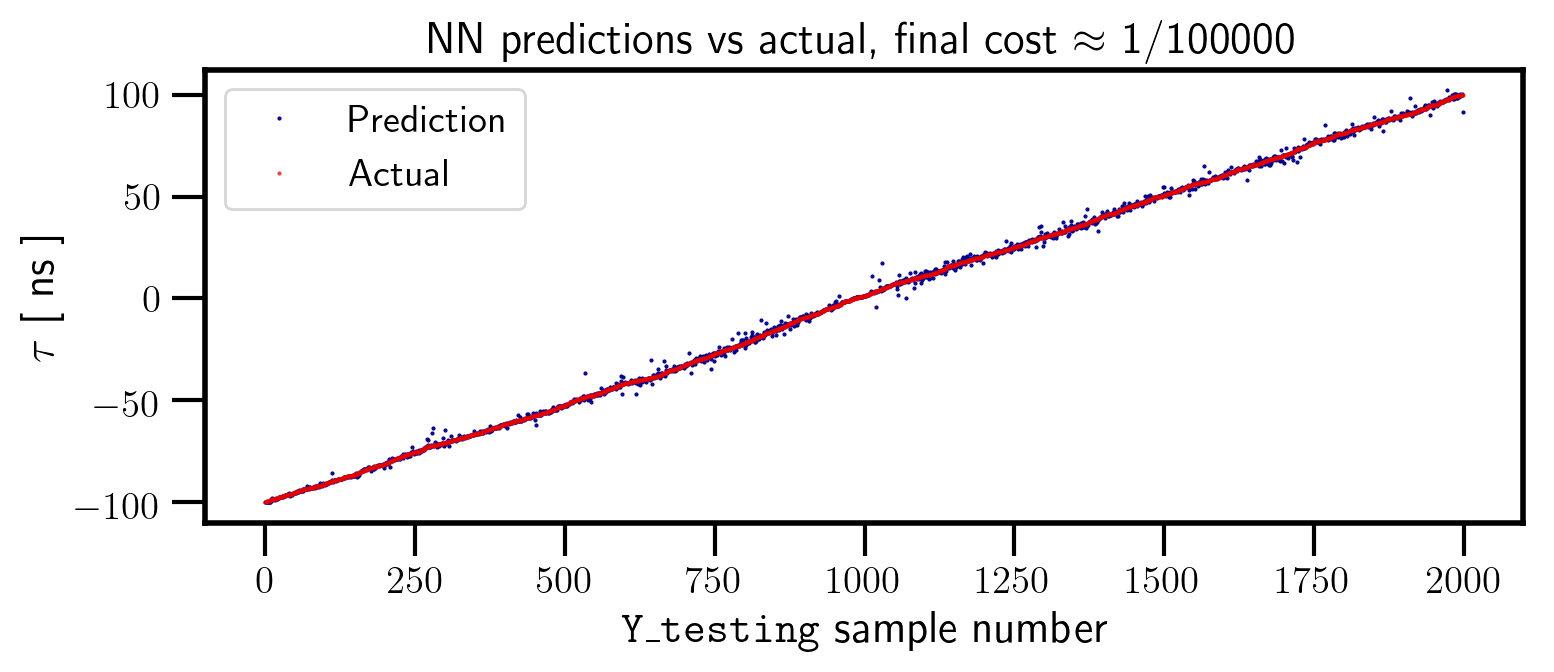

In [45]:
sorting_idx = np.argsort(Y_testing.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title(r'NN predictions vs actual, final cost $\approx$ 1/100000')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [31]:
NN_SCORE = sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

0.08950500440532119

In [69]:
np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0]))

1.1133417201063192

In [70]:
np.mean(abs(Y_testing.T[0] - prediction_unscaled.T[0]))

0.7417630006832205